In [476]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score, make_scorer, accuracy_score, recall_score, f1_score, precision_score, confusion_matrix, ConfusionMatrixDisplay

pd.set_option('display.max_rows', None)  # Display all rows
pd.set_option('display.max_columns', None) # Display all columns
pd.set_option('display.width', 1000) # Adjust display width for wide DataFrames


## Step 1: Read in the datasets and concatenate them into a single dataframe.

In [178]:
crime_df_1 = pd.read_csv('Crime_Data_from_2010_to_2019_20251031.csv')
crime_df_2 = pd.read_csv('Crime_Data_from_2020_to_Present_20251031.csv')
crime_df_1.rename(columns={'AREA ': 'AREA'}, inplace=True)
data_df = pd.concat([crime_df_1, crime_df_2], ignore_index=True)
print(data_df.shape)


(3138128, 28)


In [179]:
for c in data_df.columns:
    data_df.rename(columns={c: c.upper()}, inplace=True)
print(data_df.columns)

Index(['DR_NO', 'DATE RPTD', 'DATE OCC', 'TIME OCC', 'AREA', 'AREA NAME',
       'RPT DIST NO', 'PART 1-2', 'CRM CD', 'CRM CD DESC', 'MOCODES',
       'VICT AGE', 'VICT SEX', 'VICT DESCENT', 'PREMIS CD', 'PREMIS DESC',
       'WEAPON USED CD', 'WEAPON DESC', 'STATUS', 'STATUS DESC', 'CRM CD 1',
       'CRM CD 2', 'CRM CD 3', 'CRM CD 4', 'LOCATION', 'CROSS STREET', 'LAT',
       'LON'],
      dtype='object')


## Step 2: Data Cleaning

#### 1 Removing duplicate records. One of the easiest ways to improve the quality of our dataset. 

In [180]:
#Creates a series where the index is the DR_NO and the value is the count of occurrences
record_counts = data_df['DR_NO'].value_counts()
print(record_counts)

DR_NO
162107796    2
161805416    2
161714217    2
161914272    2
162007980    2
            ..
150513634    1
151516570    1
151013177    1
151208565    1
251904210    1
Name: count, Length: 3080319, dtype: int64


In [181]:
try:
    data_df = pd.read_csv('removed_duplicates_crime_data.csv')
except FileNotFoundError:
    record_counts = list(record_counts[record_counts>=2].index)
    duplicate_indices = []
    for i in record_counts:
        duplicate_indices.append(list(data_df[data_df['DR_NO']==i].index))

    remove_indices = [indices[0] for indices in duplicate_indices] 
    data_df.drop(remove_indices, axis='index', inplace=True)
    data_df.to_csv('removed_duplicates_crime_data.csv', index=False)

In [184]:
#Verify that removal worked
record_counts = data_df['DR_NO'].value_counts()
print(record_counts)

DR_NO
1307355      1
191605711    1
191008626    1
192012505    1
192118522    1
            ..
150210125    1
151019250    1
151804153    1
151005366    1
251904210    1
Name: count, Length: 3080319, dtype: int64


#### 2. Cleaning Location. 

According to the description on the official website, there are records with missing location data. Those need to be dealt with first.

In [185]:
test = data_df['LOCATION'].value_counts()
print(test)

LOCATION
6TH                          ST            6269
7TH                          ST            5222
9300    TAMPA                        AV    5094
6TH                                        4585
7TH                                        4391
                                           ... 
STEVELY                      DR               1
1300    BECKWITH                     AV       1
400    MARMION                      WY        1
2200    RODGERS                      AV       1
9500    LA CIENEGA                   BL       1
Name: count, Length: 84137, dtype: int64


In [186]:
# Getting some basic information and checking for null records
col = 'LOCATION'
s = data_df[col]
print("dtype:", s.dtype)
print("total rows:", len(s))
print("nulls (.isnull()):", s.isnull().sum())
print("unique (non-null):", s.nunique(dropna=True))

dtype: object
total rows: 3080319
nulls (.isnull()): 0
unique (non-null): 84137


In [187]:
#  Checking for empty or whitespace-only records
empty_mask = s.isnull() | s.astype(str).str.strip().eq('')
print("rows that are null OR only whitespace:", empty_mask.sum())
print(data_df.loc[empty_mask, :].head(10))

rows that are null OR only whitespace: 0
Empty DataFrame
Columns: [DR_NO, DATE RPTD, DATE OCC, TIME OCC, AREA, AREA NAME, RPT DIST NO, PART 1-2, CRM CD, CRM CD DESC, MOCODES, VICT AGE, VICT SEX, VICT DESCENT, PREMIS CD, PREMIS DESC, WEAPON USED CD, WEAPON DESC, STATUS, STATUS DESC, CRM CD 1, CRM CD 2, CRM CD 3, CRM CD 4, LOCATION, CROSS STREET, LAT, LON]
Index: []


In [188]:
# Checking for some common placeholders as well as specific ones
placeholders = {'N/A','NA','UNKNOWN','UNK','NONE','NOT AVAILABLE','NOT APPLICABLE','--','-','?','[]','()','TBD','NULL','MISSING', "00", "0", "0,0", "0, 0", "NaN", np.nan}
# compute normalized (uppercase, stripped) value counts
vals = s.dropna().astype(str).str.strip()
norm = vals.str.upper()
placeholder_counts = norm[norm.isin(placeholders)].value_counts()
print("Detected known placeholder tokens (normalized):")
print(placeholder_counts)

placeholder_counts = list(placeholder_counts.index)


Detected known placeholder tokens (normalized):
LOCATION
UNKNOWN    94
00          6
UNK         6
Name: count, dtype: int64


In [189]:
remove_unknowns = list(data_df[data_df["LOCATION"].isin(placeholder_counts)].index)
data_df.drop(remove_unknowns, axis='index', inplace=True)

Verify that they've been removed

In [190]:
data_df[data_df["LOCATION"].isin(placeholder_counts)].value_counts()

Series([], Name: count, dtype: int64)

In [191]:
data_df['LOCATION'].value_counts()

LOCATION
6TH                          ST             6269
7TH                          ST             5222
9300    TAMPA                        AV     5094
6TH                                         4585
7TH                                         4391
                                            ... 
13000    DE GARMO                     AV       1
10700    SAN FERNANDO                          1
REDWOOD                      BL                1
SAN ONOFRE                   DR                1
9500    LA CIENEGA                   BL        1
Name: count, Length: 84134, dtype: int64

#### 3. Clean Latitude and Longitude

In [192]:
data_df['LAT'].describe()

count    3.080213e+06
mean     3.404179e+01
std      1.092221e+00
min      0.000000e+00
25%      3.401110e+01
50%      3.406100e+01
75%      3.417070e+01
max      3.479070e+01
Name: LAT, dtype: float64

In [193]:
data_df['LON'].describe()

count    3.080213e+06
mean    -1.182367e+02
std      3.774256e+00
min     -1.188279e+02
25%     -1.184334e+02
50%     -1.183272e+02
75%     -1.182761e+02
max      0.000000e+00
Name: LON, dtype: float64

As seen above, values have been found to be 0 for both latitude and longitude. 

In [194]:
set_latlon = data_df[(data_df['LAT'] > 0.001) | (data_df['LON'] < -0.001)]
#Exclude the bad records and keep only the good ones for calculating averages

latlong_avgs = set_latlon.groupby('AREA NAME').agg({'LAT': "mean", 'LON': 'mean'})

bad_latlon_indices = data_df[(data_df['LAT'] < 0.0001) | (data_df['LON'] > -0.0001)].index.tolist()

for i in bad_latlon_indices:
    current_area = data_df.iloc[i]['AREA NAME']
    data_df.loc[i, 'LAT'] = latlong_avgs.loc[current_area]['LAT']
    data_df.loc[i, 'LON'] = latlong_avgs.loc[current_area]['LON']

#### 4. Clean Victims Ages & Other Demographic Attributes

##### Remove Negative Records

In [195]:
print(data_df['VICT AGE'].value_counts())

VICT AGE
 0      632108
 30      66603
 28      66563
 29      66427
 27      66218
         ...  
-11          2
-13          1
 114         1
 118         1
 120         1
Name: count, Length: 115, dtype: int64


In [196]:
neg_ages = data_df[data_df['VICT AGE'] < 0]['VICT AGE'].value_counts()

Saved plot to neg_age_dist.png


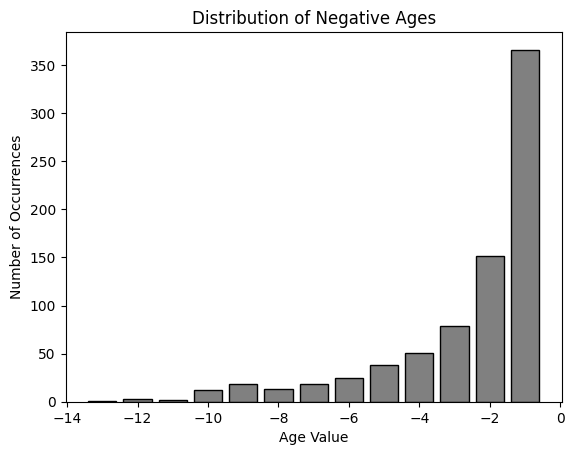

In [197]:
plt.bar(neg_ages.index, neg_ages.values, width=0.8, color='gray', edgecolor='black')
plt.title("Distribution of Negative Ages")
plt.xlabel("Age Value")
plt.ylabel("Number of Occurrences")
# plt.xticks(rotation=45, ha='right')

filename = "neg_age_dist.png"

plt.savefig(filename, dpi=300, bbox_inches='tight')
print(f"Saved plot to {filename}")

In [198]:
data_df[data_df['VICT AGE'] < 0].head(10)

,DR_NO,DATE RPTD,DATE OCC,TIME OCC,AREA,AREA NAME,RPT DIST NO,PART 1-2,CRM CD,CRM CD DESC,MOCODES,VICT AGE,VICT SEX,VICT DESCENT,PREMIS CD,PREMIS DESC,WEAPON USED CD,WEAPON DESC,STATUS,STATUS DESC,CRM CD 1,CRM CD 2,CRM CD 3,CRM CD 4,LOCATION,CROSS STREET,LAT,LON
228,221607869,2022 May 02 12:00:00 AM,2010 Jan 01 12:00:00 AM,1,16,Foothill,1612,2,668,"EMBEZZLEMENT, GRAND THEFT ($950.01 & OVER)",0344,-12,M,W,109.0,PARK/PLAYGROUND,NaN,NaN,AO,Adult Other,668.0,NaN,NaN,NaN,11200 GLENOAKS BL,NaN,34.2733,-118.4202
846,190321010,2019 Sep 18 12:00:00 AM,2010 Apr 13 12:00:00 AM,1200,3,Southwest,358,1,815,SEXUAL PENETRATION W/FOREIGN OBJECT,1501,-8,F,H,719.0,MEDICAL/DENTAL OFFICES,400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",IC,Invest Cont,815.0,NaN,NaN,NaN,WATT WY,34TH ST,34.0220,-118.2867
950,190320193,2019 Sep 07 12:00:00 AM,2010 Sep 01 12:00:00 AM,2359,3,Southwest,358,1,815,SEXUAL PENETRATION W/FOREIGN OBJECT,0500 0515,-8,M,X,719.0,MEDICAL/DENTAL OFFICES,400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",IC,Invest Cont,815.0,NaN,NaN,NaN,34TH ST,WATT WY,34.0235,-118.2857
52546,242010974,2024 Aug 23 12:00:00 AM,2010 Sep 01 12:00:00 AM,1,20,Olympic,2055,1,121,"RAPE, FORCIBLE",0515 0522 0527 0539 0541 0556 0913,-13,F,K,501.0,SINGLE FAMILY DWELLING,400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",AO,Adult Other,121.0,812.0,NaN,NaN,1000 FEDORA ST,NaN,34.0527,-118.2979
61113,131815680,2013 Sep 09 12:00:00 AM,2010 Jan 01 12:00:00 AM,800,18,Southeast,1824,2,354,THEFT OF IDENTITY,0377,-3,F,B,501.0,SINGLE FAMILY DWELLING,NaN,NaN,IC,Invest Cont,354.0,NaN,NaN,NaN,800 E 94TH ST,NaN,33.9511,-118.2608
61575,121914732,2012 Jun 28 12:00:00 AM,2010 Jun 05 12:00:00 AM,1800,19,Mission,1921,1,230,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",0554 0421 0334 1259 0449,-1,F,H,501.0,SINGLE FAMILY DWELLING,207.0,OTHER KNIFE,AO,Adult Other,230.0,NaN,NaN,NaN,12400 TELFAIR AV,NaN,34.2968,-118.4630
69460,122006402,2012 Feb 14 12:00:00 AM,2010 Nov 01 12:00:00 AM,1000,20,Olympic,2034,2,668,"EMBEZZLEMENT, GRAND THEFT ($950.01 & OVER)",0344 0342 0913 1803,-1,M,K,203.0,OTHER BUSINESS,NaN,NaN,IC,Invest Cont,668.0,NaN,NaN,NaN,3500 WILSHIRE BL,NaN,34.0618,-118.3004
69490,160217908,2016 Sep 28 12:00:00 AM,2010 Jan 01 12:00:00 AM,700,2,Rampart,247,2,860,BATTERY WITH SEXUAL CONTACT,0500 0503 1202,-6,F,X,510.0,NURSING/CONVALESCENT/RETIREMENT HOME,400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",IC,Invest Cont,860.0,NaN,NaN,NaN,400 S BONNIE BRAE ST,NaN,34.0611,-118.2707
70712,141108568,2014 Apr 07 12:00:00 AM,2010 Jan 31 12:00:00 AM,1200,11,Northeast,1136,2,354,THEFT OF IDENTITY,0377 1822 1202,-3,M,O,502.0,"MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)",NaN,NaN,IC,Invest Cont,354.0,NaN,NaN,NaN,4400 EAGLE ROCK BL,NaN,34.1241,-118.2208
71977,121122362,2012 Dec 12 12:00:00 AM,2010 Dec 01 12:00:00 AM,1200,11,Northeast,1117,1,341,"THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LI...",0344,-1,M,H,721.0,HIGH SCHOOL,NaN,NaN,IC,Invest Cont,341.0,NaN,NaN,NaN,1700 YOSEMITE DR,NaN,34.1330,-118.2031


In [199]:
#Dropping negative ages
neg_indices = data_df[data_df['VICT AGE'] < 0].index
data_df.drop(neg_indices, axis='index', inplace=True)

##### [STILL TO DO] Addressing data where the age is zero

In [202]:
zero_crimes = data_df[data_df['VICT AGE']==0]['CRM CD DESC'].value_counts()

In [203]:
zero_crimes.shape

(137,)

Saved plot to zero_age_crimes.png


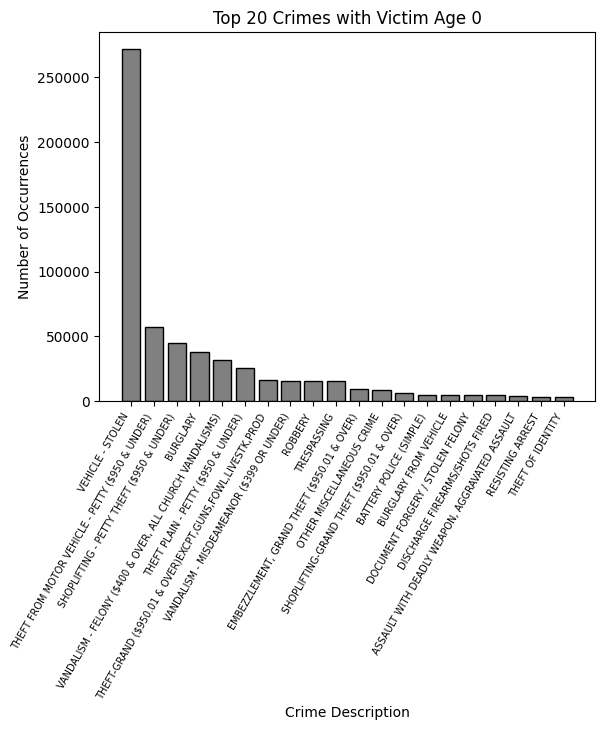

In [204]:
plt.bar(zero_crimes.index[:20], zero_crimes.values[:20], width=0.8, color='gray', edgecolor='black')
plt.title("Top 20 Crimes with Victim Age 0")
plt.xlabel("Crime Description")
plt.ylabel("Number of Occurrences")
plt.xticks(rotation=60, ha='right', fontsize=7)

filename = "zero_age_crimes.png"

plt.savefig(filename, dpi=300, bbox_inches='tight')
print(f"Saved plot to {filename}")

In [205]:
data_df[(data_df['VICT AGE'] == 0) & (data_df['VICT SEX'].isna()) & (data_df['VICT DESCENT'].isna())].shape

(337111, 28)

In [206]:
data_df[(data_df['VICT AGE'] == 0) & (data_df['VICT SEX'].isna()) & (data_df['VICT DESCENT'].isna())]['CRM CD DESC'].value_counts()

CRM CD DESC
VEHICLE - STOLEN                                            270292
THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)              55875
EMBEZZLEMENT, GRAND THEFT ($950.01 & OVER)                    6797
VEHICLE, STOLEN - OTHER (MOTORIZED SCOOTERS, BIKES, ETC)      2153
THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LIVESTK,PROD       803
                                                             ...  
DEFRAUDING INNKEEPER/THEFT OF SERVICES, $950 & UNDER             1
THROWING OBJECT AT MOVING VEHICLE                                1
THREATENING PHONE CALLS/LETTERS                                  1
BOMB SCARE                                                       1
PICKPOCKET                                                       1
Name: count, Length: 77, dtype: int64

Saved plot to victim_age_distribution.png


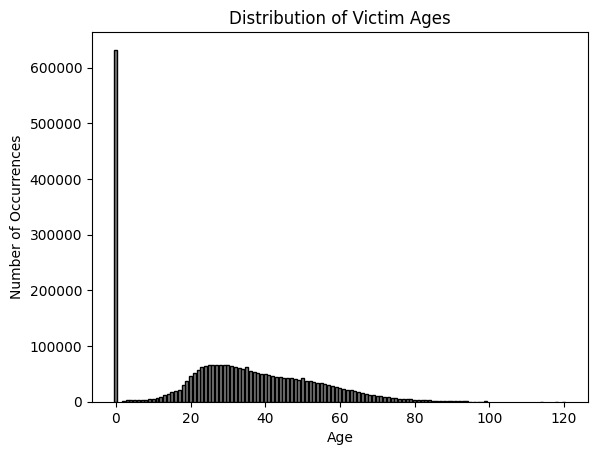

In [207]:
test = data_df['VICT AGE'].value_counts()
plt.bar(test.index, test.values, width=0.8, color='gray', edgecolor='black')
plt.title("Distribution of Victim Ages")
plt.xlabel("Age")
plt.ylabel("Number of Occurrences")

image_filename = "victim_age_distribution.png"
plt.savefig(image_filename, dpi=300, bbox_inches='tight')
print(f"Saved plot to {image_filename}")

In [208]:
data_df[(data_df['VICT AGE'] < 20) & (data_df['VICT AGE'] > 0) ]

,DR_NO,DATE RPTD,DATE OCC,TIME OCC,AREA,AREA NAME,RPT DIST NO,PART 1-2,CRM CD,CRM CD DESC,MOCODES,VICT AGE,VICT SEX,VICT DESCENT,PREMIS CD,PREMIS DESC,WEAPON USED CD,WEAPON DESC,STATUS,STATUS DESC,CRM CD 1,CRM CD 2,CRM CD 3,CRM CD 4,LOCATION,CROSS STREET,LAT,LON
16,100100552,2010 Jan 23 12:00:00 AM,2010 Jan 23 12:00:00 AM,1225,1,Central,192,2,237,CHILD NEGLECT (SEE 300 W.I.C.),1251,11,M,H,502.0,"MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)",NaN,NaN,IC,Invest Cont,237.0,NaN,NaN,NaN,1300 S FLOWER ST,NaN,34.0401,-118.2668
18,100100555,2010 Jan 23 12:00:00 AM,2010 Jan 23 12:00:00 AM,2000,1,Central,132,1,236,INTIMATE PARTNER - AGGRAVATED ASSAULT,2000,18,F,W,502.0,"MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)",400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",IC,Invest Cont,236.0,NaN,NaN,NaN,200 S GRAND AV,NaN,34.0545,-118.2499
70,100100714,2010 Mar 15 12:00:00 AM,2010 Mar 14 12:00:00 AM,2050,1,Central,162,2,624,BATTERY - SIMPLE ASSAULT,0416,16,F,H,406.0,OTHER STORE,400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",IC,Invest Cont,624.0,NaN,NaN,NaN,600 W 9TH ST,NaN,34.0451,-118.2604
74,100100723,2010 Mar 18 12:00:00 AM,2010 Mar 18 12:00:00 AM,250,1,Central,165,2,745,VANDALISM - MISDEAMEANOR ($399 OR UNDER),0329 1217,18,F,H,211.0,PAWN SHOP,NaN,NaN,IC,Invest Cont,745.0,NaN,NaN,NaN,300 E 7TH ST,NaN,34.0424,-118.2493
84,100100738,2010 Mar 22 12:00:00 AM,2010 Mar 19 12:00:00 AM,1730,1,Central,195,2,627,CHILD ABUSE (PHYSICAL) - SIMPLE ASSAULT,0416 0552,5,M,W,502.0,"MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)",400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",AA,Adult Arrest,627.0,NaN,NaN,NaN,1800 S MAIN ST,NaN,34.0317,-118.2641
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3080305,251704039,2025 Jan 14 12:00:00 AM,2025 Jan 14 12:00:00 AM,1600,17,Devonshire,1745,2,624,BATTERY - SIMPLE ASSAULT,0416 1259 2024 0419 0429 0913 1817 1251,16,F,W,721.0,HIGH SCHOOL,400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",IC,Invest Cont,624.0,NaN,NaN,NaN,10500 ZELZAH AV,NaN,34.2613,-118.5234
3080309,252104125,2025 Feb 05 12:00:00 AM,2025 Feb 05 12:00:00 AM,1555,21,Topanga,2149,2,237,CHILD NEGLECT (SEE 300 W.I.C.),NaN,4,F,O,101.0,STREET,NaN,NaN,IC,Invest Cont,237.0,NaN,NaN,NaN,CORBIN,HATTERAS,34.1958,-118.5666
3080315,250404100,2025 Feb 18 12:00:00 AM,2025 Feb 18 12:00:00 AM,1000,4,Hollenbeck,479,2,237,CHILD NEGLECT (SEE 300 W.I.C.),1258 0553 0602,11,M,B,501.0,SINGLE FAMILY DWELLING,NaN,NaN,IC,Invest Cont,237.0,NaN,NaN,NaN,3500 PERCY ST,NaN,34.0277,-118.1979
3080316,251304095,2025 Jan 31 12:00:00 AM,2025 Jan 30 12:00:00 AM,1554,13,Newton,1372,2,850,INDECENT EXPOSURE,NaN,16,F,H,101.0,STREET,NaN,NaN,IC,Invest Cont,850.0,NaN,NaN,NaN,300 E 53RD ST,NaN,33.9942,-118.2701


## Step 3: Further Pre-processing

#### 1. Changing Dates

In [209]:
data_df['DATE OCC'] = pd.to_datetime(data_df['DATE OCC'], errors='raise')
data_df['DATE RPTD'] = pd.to_datetime(data_df['DATE RPTD'], errors='raise')

C:\Users\trent\AppData\Local\Temp\ipykernel_20032\2633795116.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data_df['DATE OCC'] = pd.to_datetime(data_df['DATE OCC'], errors='raise')
C:\Users\trent\AppData\Local\Temp\ipykernel_20032\2633795116.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data_df['DATE RPTD'] = pd.to_datetime(data_df['DATE RPTD'], errors='raise')


In [210]:
data_df = data_df.copy()
data_df['MONTH OCC'] = data_df['DATE OCC'].dt.month
data_df['YEAR OCC'] = data_df['DATE OCC'].dt.year

#### 2. Preparing Demographic Data

In [211]:
def ohe_feature(data, feature):
    """
    Takes two arguments: a dataframe and a feature name (string)
    The feature is one-hot encoded into new columns and the original is dropped.
    """
    data_copy = data.copy()
    funky_ohe = OneHotEncoder()
    funky_ohe.fit([[x] for x in data_copy[feature].unique()]);
    
    test = [[x] for x in data_copy[feature]]
    test2 = funky_ohe.transform(test).toarray()
    
    names = funky_ohe.get_feature_names_out([feature])
    for i in range(len(names)):
        data_copy[names[i]] = [x[i] for x in test2]
    
    data_copy = data_copy.drop(labels = [feature], axis = 1)
    return data_copy

In [212]:
data_df['VICT SEX'].value_counts()

VICT SEX
M    1359883
F    1230482
X     151656
H        185
N         17
-          2
Name: count, dtype: int64

In [213]:
demo_df =  data_df[(data_df['VICT AGE'] > 0) & (data_df['VICT SEX'].notna()) & (data_df['VICT DESCENT'].notna())].copy()
demo_df = demo_df[(demo_df['VICT SEX'] == "M") | (demo_df['VICT SEX'] == "F")]

In [214]:
demo_df.shape

(2430525, 30)

In [215]:
demo_df = demo_df[['VICT AGE', 'VICT SEX', 'PART 1-2', 'VICT DESCENT', 'CRM CD 1', 'CRM CD 2', 'CRM CD 3', 'CRM CD 4']]

In [216]:
for i in ['CRM CD 1', 'CRM CD 2', 'CRM CD 3', 'CRM CD 4']:
    print(demo_df[demo_df[i].notna()].shape)

(2430510, 8)
(166874, 8)
(5328, 8)
(160, 8)


In [217]:
demo_df[demo_df['CRM CD 4'].notna()]

,VICT AGE,VICT SEX,PART 1-2,VICT DESCENT,CRM CD 1,CRM CD 2,CRM CD 3,CRM CD 4
8341,27,F,1,H,121.0,210.0,910.0,998.0
17559,20,F,1,B,121.0,210.0,820.0,910.0
29195,15,F,1,H,624.0,761.0,930.0,998.0
52476,32,F,1,H,121.0,210.0,820.0,910.0
75288,44,F,1,H,210.0,310.0,910.0,998.0
...,...,...,...,...,...,...,...,...
2900636,48,F,1,W,761.0,930.0,998.0,999.0
2911746,10,F,2,H,627.0,812.0,860.0,998.0
2914943,44,M,1,H,350.0,626.0,761.0,998.0
3007454,62,F,1,H,230.0,930.0,998.0,999.0


In [218]:
try:
    demo_df_crm = pd.read_csv('demo_df_crm.csv')
except FileNotFoundError:    
    demo_df_crm = pd.DataFrame()
    for i in ['CRM CD 1', 'CRM CD 2', 'CRM CD 3', 'CRM CD 4']:
        temp_df = demo_df[demo_df[i].notna()][['VICT AGE', 'VICT SEX', 'VICT DESCENT','PART 1-2' ,i]].rename(columns={i: 'CRM CD'})
        demo_df_crm = pd.concat([demo_df_crm, temp_df])

    #Need to one-hot encode the categorical features
    feature_cols = ['VICT SEX', 'VICT DESCENT', 'CRM_CD']
    for f in feature_cols:
        demo_df_crm = ohe_feature(demo_df_crm,f)
    
    demo_df_crm.to_csv('demo_df_crm.csv', index=False)

C:\Users\trent\AppData\Local\Temp\ipykernel_20032\411776216.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_copy[names[i]] = [x[i] for x in test2]
C:\Users\trent\AppData\Local\Temp\ipykernel_20032\411776216.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_copy[names[i]] = [x[i] for x in test2]
C:\Users\trent\AppData\Local\Temp\ipykernel_20032\411776216.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consid

In [219]:
demo_df_crm.shape

(2602872, 191)

In [220]:
try: 
    demo_df_nb = pd.read_csv('demo_df_nb.csv')
except FileNotFoundError:
        
    demo_df_nb = demo_df[['VICT AGE', 'VICT SEX', 'PART 1-2', 'VICT DESCENT']]
    feature_cols = ['VICT SEX', 'VICT DESCENT']
    for f in feature_cols:
        demo_df_nb = ohe_feature(demo_df_nb,f)
    demo_df_nb.to_csv('demo_df_nb.csv', index=False)

## Analysis

#### Let's begin with some time-series analysis and plots of crime relative to time

In [328]:
raw_year_counts = data_df.groupby('YEAR OCC').agg({"YEAR OCC": "count"})["YEAR OCC"]

In [329]:
slope, intercept = np.polyfit(raw_year_counts.index, raw_year_counts.values, 1)
line_x = raw_year_counts.index
line_y = slope * line_x + intercept

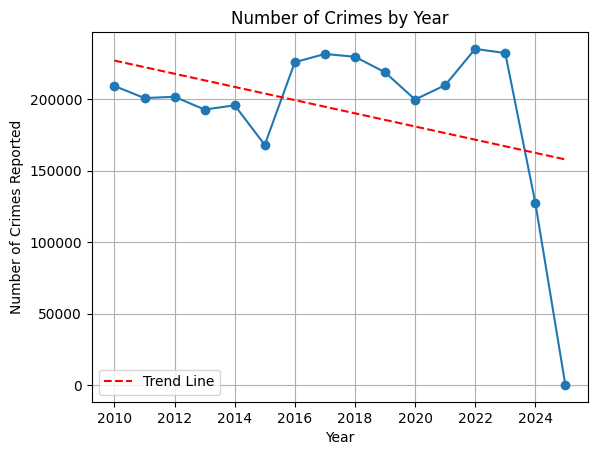

In [352]:
plt.plot(raw_year_counts.index, raw_year_counts.values, marker='o')
plt.plot(line_x, line_y, color='red', linestyle='--', label='Trend Line')
plt.grid(visible=True)
plt.xlabel("Year")
plt.ylabel("Number of Crimes Reported")
plt.title("Number of Crimes by Year")
plt.legend()
plt.savefig("crime_over_time.png")



In [369]:
raw_year_2023 = data_df.groupby('YEAR OCC').agg({"YEAR OCC": "count"})["YEAR OCC"]

In [385]:
raw_year_2023.name = 'counts'
raw_year_2023 = pd.DataFrame(raw_year_2023)
raw_year_2023 = raw_year_2023.reset_index()
raw_year_2023 = raw_year_2023[raw_year_2023["YEAR OCC"] < 2024]

In [387]:
slope, intercept = np.polyfit(raw_year_2023['YEAR OCC'], raw_year_2023['counts'], 1)
line_x = raw_year_counts.index
line_y = slope * line_x + intercept

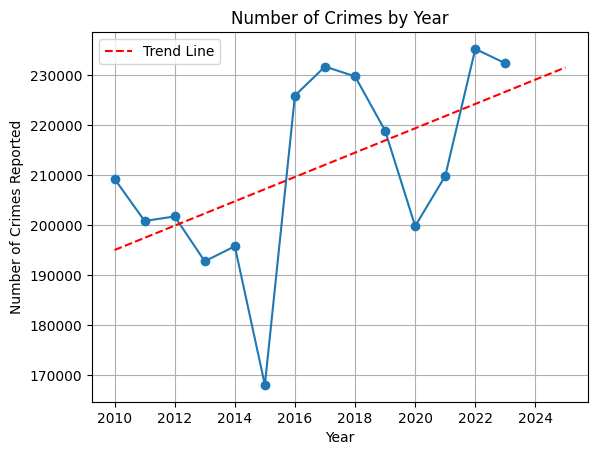

In [388]:
plt.plot(raw_year_2023['YEAR OCC'], raw_year_2023['counts'], marker='o')
plt.plot(line_x, line_y, color='red', linestyle='--', label='Trend Line')
plt.grid(visible=True)
plt.xlabel("Year")
plt.ylabel("Number of Crimes Reported")
plt.title("Number of Crimes by Year (up to 2023)")
plt.legend()
plt.savefig("crime_upto2023.png")

In [331]:
month_level_data = data_df.groupby(['YEAR OCC', 'MONTH OCC']).agg({"MONTH OCC": "count"})

In [394]:
num_colors = data_df['YEAR OCC'].value_counts().shape[0]
random_colors = np.random.rand(num_colors, 3)

In [345]:
month_level_data.loc[2010]['MONTH OCC'].values

array([19508, 16022, 18125, 17774, 17716, 17682, 17850, 17296, 16625,
       17610, 16006, 17029], dtype=int64)

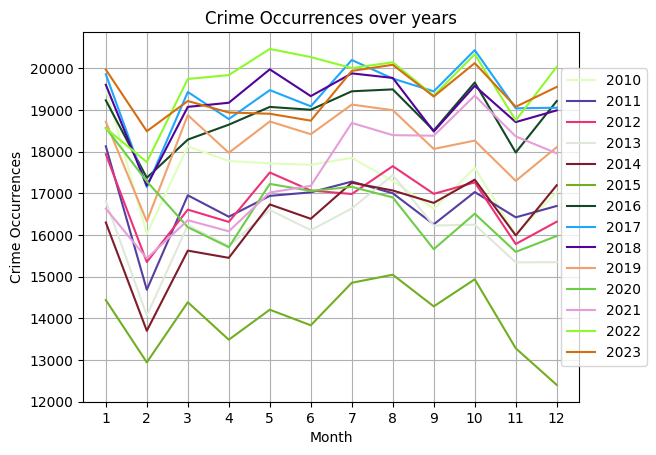

In [395]:
for i in range(2010, 2024):
    current_year_data = month_level_data.loc[i]['MONTH OCC']
    plt.plot(current_year_data.index, current_year_data.values, color=random_colors[i-2010], label = i)

plt.xlabel("Month")
plt.xticks(np.arange(1,13))
plt.ylabel("Crime Occurrences")
plt.legend(loc="center left", bbox_to_anchor=(0.95, 0.5))
plt.title("Crime Occurrences over years")
plt.grid()

plt.savefig("crime_over_seasons")

#### K-Means and Demographic Info

In [225]:
def km_metric_eval(estimator, X):
    labels = estimator.predict(X)
    return -davies_bouldin_score(X, labels)  # NEGATE so higher is better

param_grid = {
    'n_clusters': [10, 15, 20, 25, 30, 40, 50]
}

grid = GridSearchCV(KMeans(), 
                    param_grid, 
                    scoring=km_metric_eval, verbose=2
                    )

In [227]:
grid.fit(demo_df_crm)
print("Best parameters:", grid.best_params_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV] END ......................................n_clusters=10; total time=  15.6s
[CV] END ......................................n_clusters=10; total time=  14.7s
[CV] END ......................................n_clusters=10; total time=  15.0s
[CV] END ......................................n_clusters=10; total time=  14.1s
[CV] END ......................................n_clusters=10; total time=  14.6s
[CV] END ......................................n_clusters=15; total time=  16.1s
[CV] END ......................................n_clusters=15; total time=  15.7s
[CV] END ......................................n_clusters=15; total time=  15.3s
[CV] END ......................................n_clusters=15; total time=  16.1s
[CV] END ......................................n_clusters=15; total time=  17.2s
[CV] END ......................................n_clusters=20; total time=  18.0s
[CV] END ......................................n_

In [228]:
km_score = -1*grid.cv_results_['mean_test_score']

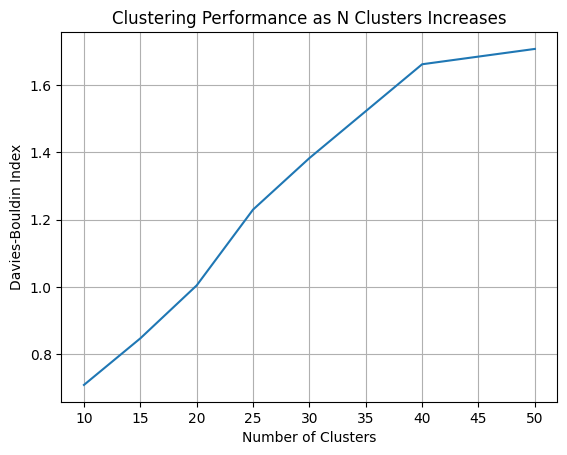

In [229]:
plt.plot(param_grid['n_clusters'], km_score)
plt.xlabel("Number of Clusters")
plt.ylabel("Davies-Bouldin Index")
plt.grid(visible=True)
plt.title("Clustering Performance as N Clusters Increases")

plt.savefig("kmeans_perf.png")

In [310]:
km_score[0]

0.708691448059135

In [405]:
km_eval_df = pd.DataFrame()
for i in ['CRM CD 1', 'CRM CD 2', 'CRM CD 3', 'CRM CD 4']:
    temp_df = demo_df[demo_df[i].notna()][['VICT AGE', 'VICT SEX', 'VICT DESCENT','PART 1-2' ,i]].rename(columns={i: 'CRM_CD'})
    km_eval_df = pd.concat([km_eval_df, temp_df])

In [406]:
km_labels = grid.best_estimator_.predict(demo_df_crm)
km_eval_df['CLUSTER'] = km_labels

In [409]:
km_eval_df.head()

,VICT AGE,VICT SEX,VICT DESCENT,PART 1-2,CRM_CD,CLUSTER
0,48,M,H,2,900,5
3,47,F,W,2,900,9
4,47,F,H,1,122,9
5,23,M,B,1,442,1
6,46,M,H,1,330,9


In [408]:
km_eval_df['CRM_CD'] = km_eval_df['CRM_CD'].astype(int)

In [410]:
km_eval_df.groupby("CLUSTER").agg("count")

,VICT AGE,VICT SEX,VICT DESCENT,PART 1-2,CRM_CD
CLUSTER,,,,,
0,326422,326422,326422,326422,326422
1,528896,528896,528896,528896,528896
2,195189,195189,195189,195189,195189
3,45597,45597,45597,45597,45597
4,262066,262066,262066,262066,262066
5,249471,249471,249471,249471,249471
6,468362,468362,468362,468362,468362
7,98157,98157,98157,98157,98157
8,150257,150257,150257,150257,150257


In [433]:
km_merge1 = km_eval_df.groupby('CLUSTER')['VICT SEX'].describe() #Clusters by sex

In [437]:
km_merge2 = km_eval_df.groupby('CLUSTER').agg({"VICT AGE": "median"}).rename(columns={'VICT AGE':"Median Age"})

In [438]:
km_merge3 = km_eval_df.groupby("CLUSTER")['VICT DESCENT'].describe()

In [439]:
km_merge_master = pd.merge(km_merge1, km_merge3, left_index=True, right_index=True)
km_merge_master = pd.merge(km_merge_master, km_merge2, left_index=True, right_index=True)
km_merge_master.rename(columns={'count_x': 'cluster size', 'top_x':'most frequent gender', 'freq_x': 'Gender Frequency', 'top_y':'most frequent descent', 'freq_y':'Descent Frequency'}, inplace=True)
km_merge_master.drop(columns={'unique_x', 'count_y', 'unique_y'}, inplace=True)
km_merge_master

,cluster size,most frequent gender,Gender Frequency,most frequent descent,Descent Frequency,Median Age
CLUSTER,,,,,,
0,326422,M,168878,H,138659,38.0
1,528896,F,285472,H,242589,25.0
2,195189,M,109269,W,64865,56.0
3,45597,F,24518,W,22730,82.0
4,262066,F,149850,H,157729,17.0
5,249471,M,137421,H,88129,50.0
6,468362,M,235613,H,194194,32.0
7,98157,M,52521,W,41997,70.0
8,150257,M,84599,W,55260,63.0


In [457]:
top5 = (
    km_eval_df
        .groupby(["CLUSTER", "CRM_CD"])
        .size()                                   # equivalent to count()
        .reset_index(name="count")                # make it a column
        .sort_values(["CLUSTER", "count"],        # sort within each CLUSTER
                     ascending=[True, False])
        .groupby("CLUSTER")
        .head(5)                                  # take top 5 per CLUSTER
)


In [458]:
top5['CRM_CD'] = top5['CRM_CD'].map(lambda x: code_to_desc_map[x])

In [459]:
top5

,CLUSTER,CRM_CD,count
16,0,BURGLARY FROM VEHICLE,31223
65,0,BATTERY - SIMPLE ASSAULT,28579
27,0,THEFT OF IDENTITY,25324
67,0,INTIMATE PARTNER - SIMPLE ASSAULT,22650
14,0,BURGLARY,21814
212,1,BATTERY - SIMPLE ASSAULT,53950
164,1,BURGLARY FROM VEHICLE,53891
214,1,INTIMATE PARTNER - SIMPLE ASSAULT,49982
187,1,THEFT PLAIN - PETTY ($950 & UNDER),36740
155,1,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",32675


In [453]:
top5['CRM_CD'].value_counts()

CRM_CD
BATTERY - SIMPLE ASSAULT                                    10
THEFT PLAIN - PETTY ($950 & UNDER)                           9
THEFT OF IDENTITY                                            8
BURGLARY FROM VEHICLE                                        7
BURGLARY                                                     7
INTIMATE PARTNER - SIMPLE ASSAULT                            3
ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT               2
THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LIVESTK,PROD     1
ROBBERY                                                      1
Code Undefined                                               1
VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)      1
Name: count, dtype: int64

#### Classification

In [460]:
demo_bayes = GaussianNB()

In [478]:
demo_df_nb.head(5)

,VICT AGE,PART 1-2,VICT SEX_F,VICT SEX_M,VICT DESCENT_-,VICT DESCENT_A,VICT DESCENT_B,VICT DESCENT_C,VICT DESCENT_D,VICT DESCENT_F,VICT DESCENT_G,VICT DESCENT_H,VICT DESCENT_I,VICT DESCENT_J,VICT DESCENT_K,VICT DESCENT_L,VICT DESCENT_O,VICT DESCENT_P,VICT DESCENT_S,VICT DESCENT_U,VICT DESCENT_V,VICT DESCENT_W,VICT DESCENT_X,VICT DESCENT_Z
0,48,2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,47,2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,47,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,23,1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,46,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [481]:
demo_df_nb['PART 1-2'] = demo_df_nb['PART 1-2'] - 1

In [482]:
X_train, X_test, y_train, y_test = train_test_split(demo_df_nb.drop('PART 1-2', axis=1), demo_df_nb['PART 1-2'])

In [483]:
demo_bayes.fit(X_train, y_train)

GaussianNB()

In [484]:
y_pred = demo_bayes.predict(X_test)

In [485]:
print("Accuracy Score of Bayes Classifier: ", accuracy_score(y_test, y_pred))
print("Precision Score of Bayes Classifier: ", precision_score(y_test, y_pred))
print("Recall Score of Bayes Classifier: ", recall_score(y_test, y_pred))
print("F1 Score of Bayes Classifier: ", f1_score(y_test, y_pred))

Accuracy Score of Bayes Classifier:  0.5040254627801037
Precision Score of Bayes Classifier:  0.4976731226192557
Recall Score of Bayes Classifier:  0.9627729919211466
F1 Score of Bayes Classifier:  0.6561642178953878


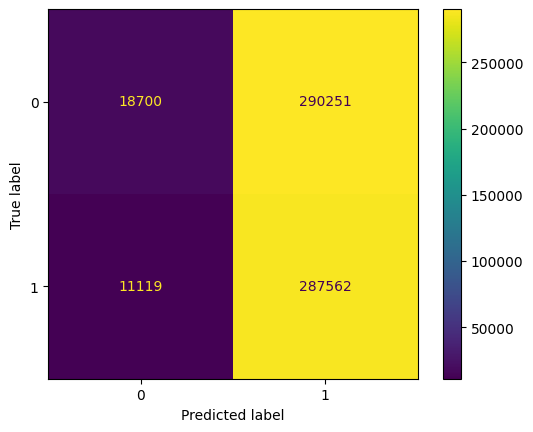

In [488]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.from_predictions(y_test, y_pred)

## Placeholder

Saved plot to top10_crime_codes.png


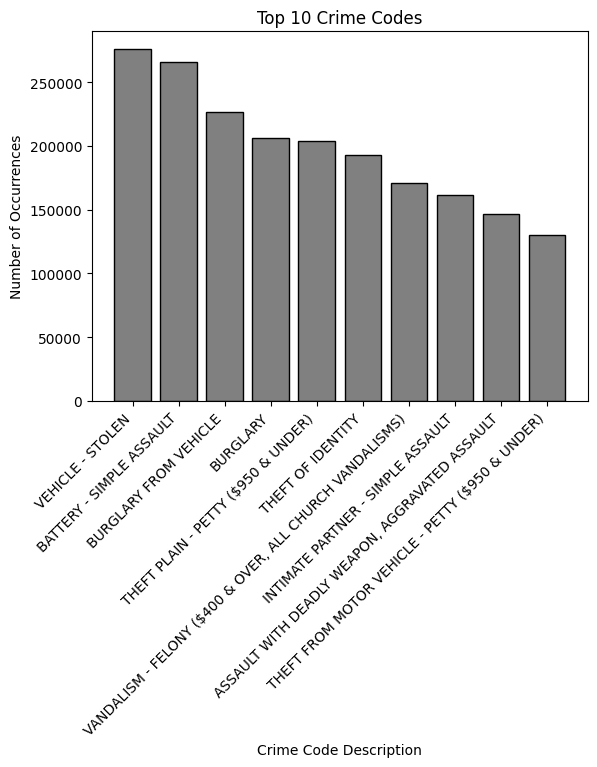

In [ ]:
plt.bar(crimeCodes[:10], crimeCodeCounts[:10], width=0.8, color='gray', edgecolor='black')
plt.title("Top 10 Crime Codes")
plt.xlabel("Crime Code Description")
plt.ylabel("Number of Occurrences")
plt.xticks(rotation=45, ha='right')

filename = "top10_crime_codes.png"

plt.savefig(filename, dpi=300, bbox_inches='tight')
print(f"Saved plot to {filename}")


In [93]:
data_df.dtypes

DR_NO                      int64
DATE RPTD         datetime64[ns]
DATE OCC          datetime64[ns]
TIME OCC                   int64
AREA                       int64
AREA NAME                 object
RPT DIST NO                int64
PART 1-2                   int64
CRM CD                     int64
CRM CD DESC               object
MOCODES                   object
VICT AGE                   int64
VICT SEX                  object
VICT DESCENT              object
PREMIS CD                float64
PREMIS DESC               object
WEAPON USED CD           float64
WEAPON DESC               object
STATUS                    object
STATUS DESC               object
CRM CD 1                 float64
CRM CD 2                 float64
CRM CD 3                 float64
CRM CD 4                 float64
LOCATION                  object
CROSS STREET              object
LAT                      float64
LON                      float64
MONTH OCC                  int32
YEAR OCC                   int32
dtype: obj

In [297]:
code_to_desc_map = dict()
for i in data_df["CRM CD"].value_counts().index.to_list():
    code_to_desc_map[i] = data_df[data_df["CRM CD"] == i]["CRM CD DESC"].head(1).values[0]

In [298]:
print(code_to_desc_map)

{510: 'VEHICLE - STOLEN', 624: 'BATTERY - SIMPLE ASSAULT', 330: 'BURGLARY FROM VEHICLE', 310: 'BURGLARY', 440: 'THEFT PLAIN - PETTY ($950 & UNDER)', 354: 'THEFT OF IDENTITY', 740: 'VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)', 626: 'INTIMATE PARTNER - SIMPLE ASSAULT', 230: 'ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT', 420: 'THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)', 210: 'ROBBERY', 745: 'VANDALISM - MISDEAMEANOR ($399 OR UNDER)', 341: 'THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LIVESTK,PROD', 442: 'SHOPLIFTING - PETTY THEFT ($950 & UNDER)', 930: 'CRIMINAL THREATS - NO WEAPON DISPLAYED', 331: 'THEFT FROM MOTOR VEHICLE - GRAND ($950.01 AND OVER)', 888: 'TRESPASSING', 901: 'VIOLATION OF RESTRAINING ORDER', 761: 'BRANDISH WEAPON', 956: 'LETTERS, LEWD  -  TELEPHONE CALLS, LEWD', 236: 'INTIMATE PARTNER - AGGRAVATED ASSAULT', 946: 'OTHER MISCELLANEOUS CRIME', 900: 'VIOLATION OF COURT ORDER', 649: 'DOCUMENT FORGERY / STOLEN FELONY', 480: 'BIKE - STOLEN', 350: 'THEFT, PE

In [421]:
code_to_desc_map[998] = 'Code Undefined'